In [1]:
!pip install sentencepiece
!pip install demoji
!pip install tweet-preprocessor
!pip install transformers[sentencepiece]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.4 MB/s eta 0:00:00


In [2]:
from IPython.display import clear_output

In [3]:
import gdown
folder_ids = ["13awgCt1kZh_Q_RGSLCUpoxl1L9LV5Ddu"]
for id in folder_ids:
    gdown.download_folder(id=id)
clear_output(wait=True); print()

In [4]:
!ls Dataset

Constraint_English_Test.xlsx   Constraint_English_Val.xlsx
Constraint_English_Train.xlsx  english_test_with_labels.xlsx


In [5]:
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch.nn.functional as F
import torch
import copy
from transformers import BertModel, RobertaModel, BertTokenizer, RobertaTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, random_split, Dataset, DataLoader, IterableDataset, ConcatDataset
import sklearn
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import random
import preprocessor as p
# model_path = ''

2025-09-03 07:54:11.385977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756886051.693598      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756886051.781982      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
%matplotlib inline
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 8})

In [7]:
## hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
embed_vector_size = 256
num_classes = 2
lr = 2e-5
num_epochs = 2
model_name = "microsoft/deberta-v3-large"
RANDOM_SEED = 42

In [8]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value)  
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
random_seed(RANDOM_SEED, True)

In [9]:
class FNDDataset(Dataset):
    def __init__(self, path, device="cpu"):
        self._path = path
        assert path.endswith('.xlsx'), "expected a excel file"
        self.df = pd.read_excel(path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.classes = ['real', 'fake']
        self.nclasses = len(self.classes)
        self.columns = self.df.columns
    def __len__(self) -> int:
        return self.df.shape[0]

    def get_label(self, labels):
        assert isinstance(labels, np.ndarray)
        assert labels.ndim == 1
        indices = torch.tensor([self.classes.index(label) for label in labels])
        return indices.to(torch.float)

    def get_label_encoded(self, labels):
        assert isinstance(labels, np.ndarray)
        assert labels.ndim == 1
        batch_size = labels.shape[0]
        vec = torch.zeros(batch_size, self.nclasses, dtype=torch.float)
        indices = torch.tensor([self.classes.index(label) for label in labels])
        vec[torch.arange(batch_size), indices] = 1
        return vec.squeeze()
        
    def __getitem__(self, idx):
        sentences = self.df.tweet.iloc[idx] if isinstance(idx, int) else self.df.tweet.iloc[idx].tolist()
        labels = np.array([self.df.label.iloc[idx]]) if isinstance(idx, int) else self.df.label.iloc[idx].values
        return *self.tokenize(sentences, max_length=embed_vector_size), self.get_label(labels)
        
    def tokenize(self, sentences, max_length=256):
        inputs = self.tokenizer(sentences, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs = {key: value.squeeze() for key, value in inputs.items()}
        return inputs['input_ids'], inputs['attention_mask']

In [10]:
train_csv = "/kaggle/working/Dataset/Constraint_English_Train.xlsx"
# test_csv = "/kaggle/working/Dataset/Constraint_English_Test.xlsx"
val_csv = "/kaggle/working/Dataset/Constraint_English_Val.xlsx"

train_dataset = FNDDataset(train_csv, device=device)
# test_dataset = FNDDataset(test_csv, device=device)
val_dataset = FNDDataset(val_csv, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [11]:
len(train_dataset)

6420

In [12]:
len(val_dataset)

2140

In [11]:
def save_metrics(save_path, epochs, model, optimizer, F1):

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'epochs': epochs+1,
                  'F1': F1}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, model, optimizer):
    try: 
        state_dict = torch.load(load_path, map_location=device)
        model.load_state_dict(state_dict['model_state_dict'])
        optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    except: 
        state_dict = {}

    print(f'Model loaded from <== {load_path}')
    return state_dict.get('epochs', 0), state_dict.get('F1', 0)

In [12]:
class Embedding(torch.nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.embeddings = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.output_vector_size = self.embeddings.config.hidden_size * 3

    def forward(self, input_ids, mask):
        outputs = self.embeddings(input_ids, mask)
        out = outputs.last_hidden_state # -> (batch_size, num_words, 768)
        mean_pooling = torch.mean(out, 1)
        max_pooling, _ = torch.max(out, 1)
        embed = torch.cat((out[:, 0, :], mean_pooling, max_pooling), 1) # -> (batch_size, 768 * 3)
        y_pred = self.dropout(embed)
        return y_pred


class Classifier(nn.Module):
    def __init__(self, input_size=768 * 2, hidden_size=128, num_classes=5, dropout_prob=0.3):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, 1, bias=True) # add the fc1 layer too

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        logits = self.fc2(x)
        return logits


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embed = Embedding()
        # self.fe = BiLSTMAttentionClassifier(self.embed.output_vector_size, 128)
        self.classifier = Classifier(self.embed.output_vector_size, 64)

    def forward(self, input_ids, mask):
        x = self.embed(input_ids, mask)
        # x = self.fe(x)
        logits = self.classifier(x)
        return F.sigmoid(logits)


In [13]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
 
def get_predicted(preds):
    ones = torch.ones_like(preds)
    zeros = torch.zeros_like(preds)
    confidence = 0.7
    pred_flat = torch.where(preds > confidence, ones, zeros)
    return pred_flat.squeeze()

def evaluate(test_dataloader, model):
    model.eval()
    y_preds, y_test = np.array([]), np.array([])

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        with torch.no_grad():        
            ypred = model(b_input_ids, b_input_mask)
        ypred = ypred.cpu()
        label_ids = b_labels.to('cpu').squeeze()
        y_preds = np.hstack((y_preds, get_predicted(ypred).numpy()))
        y_test = np.hstack((y_test, label_ids.numpy()))

    weighted_f1 = f1_score(y_test, y_preds, average='weighted')
    return weighted_f1, y_preds, y_test
 
def train(training_dataloader, validation_dataloader, model, filepath, weights = None, learning_rate = 2e-5, epochs = 4, print_every = 10):
    total_steps = len(training_dataloader) * epochs
    no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
    torch.cuda.empty_cache()
    scaler = torch.amp.GradScaler('cuda')
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps = 1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)
    
    current_epoch, best_weighted_f1 = load_metrics(filepath, model, optimizer)
    criterion = nn.BCELoss() if weights == None else nn.BCELoss(weight=weights)
    losses = []
    for epoch_i in range(current_epoch, epochs):
        model.train()
        for batch in tqdm(training_dataloader):
            b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).squeeze()
            outputs = model(b_input_ids, b_input_mask).squeeze()
            loss = criterion(outputs, b_labels)
            losses.append(loss.item())
            optimizer.zero_grad()
            # loss.backward()
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # optimizer.step()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
 
        print('### Validation Set Stats')
        weighted_f1, ypred, ytest = evaluate(validation_dataloader, model)
        print("  Weighted F1: {0:.2f}".format(weighted_f1))
        if weighted_f1 > best_weighted_f1:
            best_weighted_f1 = weighted_f1
            save_metrics(filepath, epoch_i, model.module.embed.embeddings, optimizer, weighted_f1)
    return losses

In [14]:
for data in train_dataset:
    print(data)
    break

(tensor([    1,   279, 16176,  1049,  1639, 47001,  4230,  5876,   260,   344,
         1042,   262, 31309,   267,  1142,  6448,   457,   467,  2175,   281,
          536,   263, 85980, 10339,   260,   279,  1142,   264,   436,  3224,
          288,  5288,   803,   528,   355,   561,   260,     2,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,

In [15]:
len(train_dataset)

6420

In [16]:
val_dataset[:10][2]

tensor([1., 1., 1., 1., 0., 0., 0., 0., 1., 1.])

In [17]:
model = Model().to(device)
model = nn.DataParallel(model)
model = torch.compile(model)
optimizer = AdamW(model.parameters(), lr=lr, eps = 1e-8)

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

In [18]:
losses = train(train_dataloader, val_dataloader, model, 'covid-fnd-labse-base-new.pt',epochs=num_epochs)

Model loaded from <== covid-fnd-labse-base-new.pt


  0%|          | 0/803 [00:00<?, ?it/s]W0828 14:53:18.310000 36 torch/_logging/_internal.py:1089] [0/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/variables/functions.py:679: UserWarning: Graph break due to unsupported builtin sys._getframe. This function is either a Python builtin (e.g. _warnings.warn) or a third-party C/C++ Python extension (perhaps created with pybind). If it is a Python builtin, please file an issue on GitHub so the PyTorch team can add support for it and see the next case for a workaround. If it is a third-party C/C++ Python extension, please either wrap it into a PyTorch-understood custom operator (see https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html for more details) or, if it is traceable, use torch.compiler.allow_in_graph.
  torch._dynamo.utils.warn_once(msg)
100%|██████████| 803/803 [20:08<00:00,  1.51s/it]


### Validation Set Stats
  Weighted F1: 0.95
Model saved to ==> covid-fnd-labse-base-new.pt


100%|██████████| 803/803 [20:03<00:00,  1.50s/it]


### Validation Set Stats
  Weighted F1: 0.96
Model saved to ==> covid-fnd-labse-base-new.pt


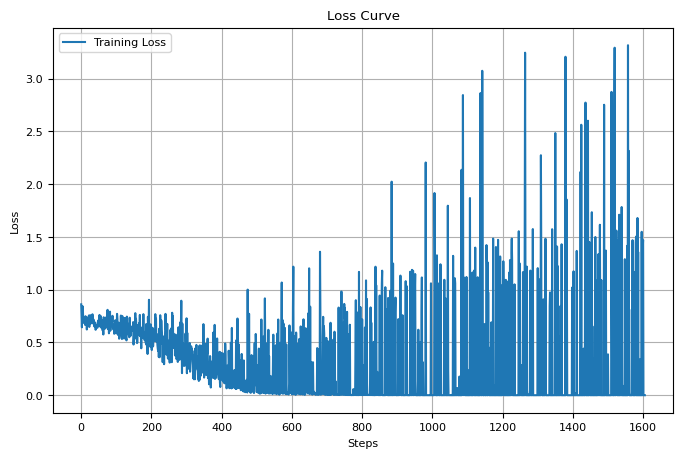

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
_, ypred, ytest = evaluate(val_dataloader, model)
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score, classification_report
array = confusion_matrix(ytest, ypred)

In [21]:
precision, recall, f1, _ = precision_recall_fscore_support(
                ytest, ypred, average='weighted', zero_division=0)
accuracy = accuracy_score(ytest, ypred)
f1_macro = f1_score(ytest, ypred, average="macro") 
f1_micro = f1_score(ytest, ypred, average="micro")  
ytest_bin = label_binarize(ytest, classes=[0, 1])  
ypred_bin = label_binarize(ypred, classes=[0, 1])  

fpr = {}
tpr = {}
roc_auc = {}
for i in range(ytest_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], ypred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["aoc"], tpr["aoc"], _ = roc_curve(ytest_bin.ravel(), ypred_bin.ravel())
roc_auc["aoc"] = auc(fpr["aoc"], tpr["aoc"])

print(f"Accuracy: {accuracy:.4f}")
print(f"precision: {precision: .4f}")
print(f"recall: {recall: .4f}")
print(f"Weighted F1: {f1: .4f}")
print(f"Macro F1: {f1_macro : .4f}")
print(f"Micro F1: {f1_micro : .4f}")
print(f"AUC: {roc_auc['aoc']: .4f}")
print(classification_report(ytest, ypred))

Accuracy: 0.9626
precision:  0.9632
recall:  0.9626
Weighted F1:  0.9626
Macro F1:  0.9625
Micro F1:  0.9626
AUC:  0.9617
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      1120
         1.0       0.98      0.94      0.96      1020

    accuracy                           0.96      2140
   macro avg       0.96      0.96      0.96      2140
weighted avg       0.96      0.96      0.96      2140



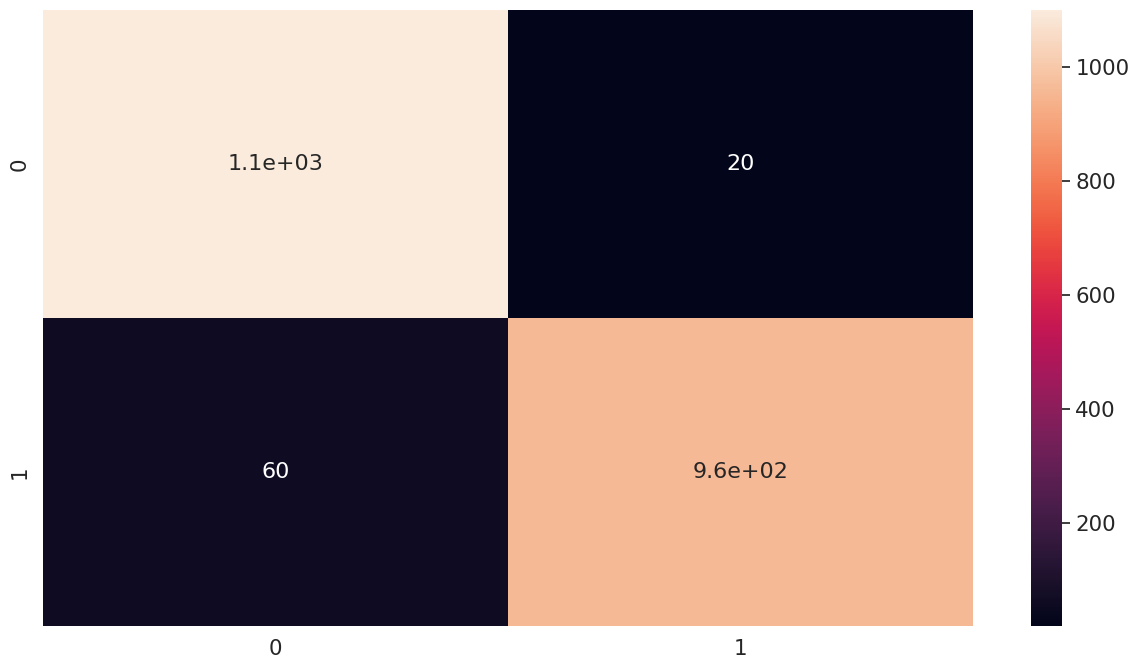

In [22]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, range(val_dataset.nclasses), range(val_dataset.nclasses))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()